In [ ]:
##Install Packages

In [ ]:
import subprocess, sys
packages = ["netCDF4", "global_land_mask", "matplotlib",
            "numpy", "tensorflow"]
for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 567.0 kB/s eta 0:00:00a 0:00:01
   ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/601.4 MB 879.9 kB/s eta 0:11:06

##load the modules in the packages (e.g., `Dataset`) or load the packages and assign a shorter object name for the packages (e.g., `import numpy as np`) for a cleaner use throughout the notebook.

In [2]:
from netCDF4 import Dataset
import numpy as np
from global_land_mask import globe
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] = 'auto'

In [ ]:
##Retrieve Files Online

In [4]:
import boto3

# Initialize a session using Boto3
session = boto3.Session()
s3 = session.client('s3')

# Specify bucket and key prefix to the Jose TC PRIMED folder on S3
BUCKET_NAME = "nccf-ssbx-ingest-trust-us-east-1-853468063363"
TRAIN_KEY_PREFIX = "NCAI/TCPRIMED/2017/AL/12/"

# Specify the names of the files we will use from the Jose TC PRIMED folder on S3
TRAIN_FILE_NAMES = [
    "TCPRIMED_v01r00-final_AL122017_GMI_GPM_020015_20170906043506.nc",
    "TCPRIMED_v01r00-final_AL122017_GMI_GPM_020053_20170908155108.nc",
    "TCPRIMED_v01r00-final_AL122017_GMI_GPM_020062_20170909050809.nc",
    "TCPRIMED_v01r00-final_AL122017_GMI_GPM_020084_20170910153710.nc",
    "TCPRIMED_v01r00-final_AL122017_GMI_GPM_020093_20170911045711.nc",
    "TCPRIMED_v01r00-final_AL122017_GMI_GPM_020124_20170913044913.nc",
    "TCPRIMED_v01r00-final_AL122017_GMI_GPM_020130_20170913143513.nc",
    "TCPRIMED_v01r00-final_AL122017_GMI_GPM_020139_20170914035614.nc",
    "TCPRIMED_v01r00-final_AL122017_GMI_GPM_020170_20170916034716.nc"
                   ]

# Declare TRAIN_DS as a dictionary
TRAIN_DS = {}

# Loop through each train file name
for train_file_name in TRAIN_FILE_NAMES:

    # Join bucket, key prefix and train_file_name to produce a complete link
    # Retrieve the contents of the TC PRIMED file from the complete link
    response = s3.get_object(Bucket=BUCKET_NAME, Key=TRAIN_KEY_PREFIX + train_file_name)

    # Load the contents of the TC PRIMED file in an "instance" type into the
    # dictionary TRAIN_DS with the file name as the dictionary key
    TRAIN_DS[train_file_name] = Dataset(train_file_name, memory=response['Body'].read())

In [5]:
# Specify key prefix to the Maria TC PRIMED folder on S3
VAL_KEY_PREFIX = "NCAI/TCPRIMED/2017/AL/15/"

# Specify the names of the files we will use from the Maria TC PRIMED folder on S3
VAL_FILE_NAMES = [
    "TCPRIMED_v01r00-final_AL152017_GMI_GPM_020200_20170918020118.nc",
    "TCPRIMED_v01r00-final_AL152017_GMI_GPM_020253_20170921122521.nc",
    "TCPRIMED_v01r00-final_AL152017_GMI_GPM_020284_20170923121423.nc",
    "TCPRIMED_v01r00-final_AL152017_GMI_GPM_020345_20170927101927.nc",
                 ]

# Declare VAL_DS as a dictionary
VAL_DS = {}

# Loop through each val file name
for val_file_name in VAL_FILE_NAMES:

    # Join bucket, key prefix and val_file_name to produce a complete link
    # Retrieve the contents of the TC PRIMED file from the complete link
    response = s3.get_object(Bucket=BUCKET_NAME, Key=VAL_KEY_PREFIX + val_file_name)

    # Load the contents of the TC PRIMED file in an "instance" type into the
    # dictionary VAL_DS with the file name as the dictionary key
    VAL_DS[val_file_name] = Dataset(val_file_name, memory=response['Body'].read())

In [6]:
# Specify key prefix to the Irma TC PRIMED folder on S3
TEST_KEY_PREFIX = "NCAI/TCPRIMED/2017/AL/11/"

# Specify the names of the files we will use from the Irma TC PRIMED folder on S3
TEST_FILE_NAMES = [
    "TCPRIMED_v01r00-final_AL112017_GMI_GPM_019929_20170831163031.nc",
    "TCPRIMED_v01r00-final_AL112017_GMI_GPM_019938_20170901054701.nc",
    "TCPRIMED_v01r00-final_AL112017_GMI_GPM_020007_20170905165205.nc",
    "TCPRIMED_v01r00-final_AL112017_GMI_GPM_020038_20170907164107.nc",
                  ]

# Declare TEST_DS as a dictionary
TEST_DS = {}

# Loop through each test file name
for test_file_name in TEST_FILE_NAMES:

    # Join bucket, key prefix and test_file_name to produce a complete link
    # Retrieve the contents of the TC PRIMED file from the complete link
    response = s3.get_object(Bucket=BUCKET_NAME, Key=TEST_KEY_PREFIX + test_file_name)

    # Load the contents of the TC PRIMED file in an "instance" type into the
    # dictionary VAL_DS with the file name as the dictionary key
    TEST_DS[test_file_name] = Dataset(test_file_name, memory=response['Body'].read())

In [7]:
###Data Pre-Processing: Generating Input Features and Target Labels
def generate_features_and_labels(FILE_DICT, FILE_NAMES, frequencies):
    """
    Generate input features and target labels from a set of TC PRIMED GPM
    overpass files

    Parameters
    ----------
    FILE_DICT : dictionary
        dictionary containing the NetCDF instances for each file in FILE_NAMES
    FILE_NAMES: array-like
        list of TC PRIMED GPM file names from which we want to generate the input
        features and target labels
    frequencies : array-like
        list of GPM observation frequencies we want to use as the input
        features

    Returns
    -------
    features : array-like
        array of passive microwave brightness temperatures at each pixel as
        our input features
    labels : array-like
        array of GPROF surface precipitation rate at each pixel as our target
        labels
    """
    # Value to replace masked data and to ignore when generating input
    # features and target labels
    _FillValue = -999.0

    # Since we don't usually know the size of our sample, we will generate an
    # empty array and continuously append values

    # Generate a dictionary of emtpy array to store brightness temperature
    # values for each observing frequency.
    feature_lists = {}
    for frequency in frequencies:
        feature_lists[frequency] = np.array([])

    # Generate empty array to store GPROF surface precipitation rate
    labels = np.array([])

    # Loop through each TC PRIMED GPM file
    for FILE_NAME in FILE_NAMES:

        # Load the latitude and longitude values of the observation pixels
        latitude = FILE_DICT[FILE_NAME]["passive_microwave/S1/latitude"][:]
        longitude = FILE_DICT[FILE_NAME]["passive_microwave/S1/longitude"][:]

        # The global_land_mask package uses longitude values in the range
        # [-180, 180) to determine if a point is over the ocean. We will
        # have to convert the default longitude values in TC PRIMED with a
        # longitude range of [0, 360) to the longitude range of [-180,180)
        longitude[longitude >= 180] -= 360

        # Load the surface preciptitation rate from GPROF
        # Replace the masked value with the specified _FillValue
        surfaceprecip = FILE_DICT[FILE_NAME]["GPROF/S1/surfacePrecipitation"][:].filled(_FillValue)

        # Using the latitude and longitude values of the pixels, find the
        # pixels that are over the ocean. Pixels that are over the ocean will
        # have a value of "True"
        ocean_pixels = globe.is_ocean(latitude, longitude)

        # Find the indices of the pixels that are over the ocean
        select_idx = np.argwhere(ocean_pixels == True)

        # Find the indices of the GPROF surface precipitation rate with a valid
        # value that is not the _FillValue. Append the indices to the indices of
        # pixels over the ocean
        select_idx = np.append(select_idx, np.argwhere(surfaceprecip != _FillValue), axis=0)

        # Find all unique indices
        # Select the unique indices only if there are more than one in the
        # original array (indicating an overlap between the indices for pixels
        # over the ocean and GPROF pixels that are not _FillValue)
        unique_idx, count_idx = np.unique(select_idx, axis=0, return_counts=True)
        select_idx = unique_idx[count_idx > 1]

        # Initialize dictionary to store brightness temperature fields
        TB = {}

        # Loop through each observation frequency we want to use as our
        # input feature
        for frequency in frequencies:

            # Load the brightness temperature field
            # Replace the masked value with the specified _FillValue
            TB[frequency] = FILE_DICT[FILE_NAME]["passive_microwave/S1/TB_" + frequency][:].filled(_FillValue)

            # Append indices of brightness temperature values that are not
            # _FillValue to the indices we have already selected above
            select_idx = np.append(select_idx, np.argwhere(TB[frequency] != _FillValue), axis=0)

            # Repeat the steps above
            # Iteratively select indices for pixels that are over the ocean,
            # have GPROF pixels that are not _FillValue, have brightness
            # temperature pixels that are not _FillValue, etc.
            unique_idx, count_idx = np.unique(select_idx, axis=0, return_counts=True)
            select_idx = unique_idx[count_idx > 1]

        # Loop through each index we have selected
        for idx in select_idx:

            # Append the value of GPROF surface precipitation rate into our
            # target label array
            labels = np.append(labels, surfaceprecip[idx[0],idx[1]])

            # Loop through each observation frequency
            for frequency in frequencies:

                # Append the value of the brightness temperature into our
                # input feature array
                feature_lists[frequency] = np.append(feature_lists[frequency], TB[frequency][idx[0],idx[1]])

    # Now, convert dictionary of input feature arrays into a 2-D array
    # of input features
    for frequency in frequencies:

        if frequency == frequencies[0]:

            features = feature_lists[frequency]

        else:

            features = np.vstack((features,feature_lists[frequency]))

    return np.transpose(features), labels

In [ ]:
## Data Pre-Processing: Feature Selection

NASA briefly describes how the [different GMI observation frequencies](https://gpm.nasa.gov/missions/GPM/GMI) relate to the different types of atmospheric processes. The following list shows the GMI observation frequencies we can use in this notebook:
- 10.65V
- 10.65H
- 18.7V
- 18.7H
- 23.8V
- 36.64V
- 36.64H
- 89.0V
- 89.0H

In [24]:
frequencies = ["10.65V", "10.65H","36.64V", "36.64H", "89.0V", "89.0H"]

Generate input features and target labels for our trainining, validation, and input sets.

In [25]:
train_features, train_labels = generate_features_and_labels(TRAIN_DS, TRAIN_FILE_NAMES, frequencies)

In [26]:
val_features, val_labels = generate_features_and_labels(VAL_DS, VAL_FILE_NAMES, frequencies)

In [27]:
test_features, test_labels = generate_features_and_labels(TEST_DS, TEST_FILE_NAMES, frequencies)

In [28]:
print(val_features)
print(val_labels)

[[264.79000854 251.58999634 267.01998901 249.72000122 283.17999268
  277.91000366]
 [259.45001221 241.57000732 261.79000854 239.32000732 282.8999939
  276.17999268]
 [253.47000122 226.71000671 263.60998535 242.44000244 283.63000488
  279.54000854]
 ...
 [172.53999329  94.40000153 225.28999329 170.44999695 275.35998535
  258.70999146]
 [173.61000061  94.62000275 223.21000671 167.07000732 274.6000061
  256.70999146]
 [173.33999634  93.86000061 223.3999939  166.25       274.61999512
  255.44000244]]
[0.08 0.07 0.07 ... 0.01 0.01 0.01]


## About the Machine Learning Model: The Artificial Neural Network
Here, we provide a basic description of the [artificial neural network](https://www.ibm.com/topics/neural-networks). In *very* simplified terms, the artificial neural network is similar to linear regression but with additional non-linear steps. Let's briefly take a look at the linear regression as an analogy. A linear regression model takes the form of:
$$y = mx + b$$
Where $y$ is your predicted value, $x$ is your input value, $m$ is the weight, and $b$ is the bias. Now, let's say you have an artificial neural network model with two hidden layers. In the first hidden layer, the model takes the input values ($x$) and generates multiple subsets of linear regression models that each produce a predicted value ($y$). The number of linear regression models depends on the number of nodes in the first hidden layer, which is specified by the user. At this point, the model adds non-linearity by applying an activation function to the predicted values from the first hidden layer. This activation function is also specified by the user.

After the activation function is applied to the predicted values from the first hidden layer, the predicted values become the input values for the next hidden layer, and the process repeats. In the final layer, no activation function is applied and the model linearly regresses the predicted values from the last hidden layer to the target label. During training, the artificial neural network finds the weight ($m$) and bias ($b$) values for each subset of linear regression models by minimizing a loss function (e.g., mean squared error).

From the basic description of the artificial neural network model above, you have a few basic [model hyperparameters](https://www.youtube.com/watch?v=h291CuASDno) to choose:
- the number of hidden layers
- the number of nodes in each hidden layer
- the activation function
- the loss function

In addition, there are a few other hyperparameters that we did not discuss, but still need to be selected:
- the optimizer, which is a function that determines how the weights and biases are modified
- the batch size, which tells the model how many samples from the full training set the model should train on before updating the weights and biases
- the number of epochs, which tells the model how many times to train the model using the full training set

In [ ]:
## Data Pre-Processing:Scaling the Input Data

In [29]:
def obtain_feature_min_max(frequencies, train_features, val_features, test_features):
    """
    Obtain min and max values of input features from the training, validation,
    and testing sets

    Parameters
    ----------
    frequencies : array-like
        list of GPM observation frequencies we want to use as the input
        features
    train_features : array-like
        2-D array of input features from the training set
    val_features : array-like
        2-D array of input features from the validation set
    test_features : array-like
        2-D array of input features from the testing set

    Returns
    -------
    feature_min : dict
        dictionary containing the minimum value of each observation frequency
        in the input features
    feature_max : dict
        dictionary containing the maximum value of each observation frequency
        in the input features
    """

    feature_min = {}
    feature_max = {}

    for freq_idx, frequency in enumerate(frequencies):

        all_features = np.hstack((train_features[:, freq_idx],
                                  val_features[:, freq_idx],
                                  test_features[:, freq_idx]))

        feature_min[frequency] = np.min(all_features)
        feature_max[frequency] = np.max(all_features)

    return feature_min, feature_max

In [ ]:
##the minimum and maximum values of each of our input features using the function we have generated. 

In [30]:
feature_min, feature_max = obtain_feature_min_max(frequencies, train_features, val_features, test_features)

for frequency in frequencies:

    print("Observation frequency: ", frequency)
    print("Minimum value: ", feature_min[frequency])
    print("Maximum value: ", feature_max[frequency])
    print(" ")

Observation frequency:  10.65V
Minimum value:  162.7899932861328
Maximum value:  274.2200012207031
 
Observation frequency:  10.65H
Minimum value:  85.19000244140625
Maximum value:  268.7200012207031
 
Observation frequency:  36.64V
Minimum value:  164.36000061035156
Maximum value:  282.2300109863281
 
Observation frequency:  36.64H
Minimum value:  131.0800018310547
Maximum value:  280.0400085449219
 
Observation frequency:  89.0V
Minimum value:  64.87999725341797
Maximum value:  290.25
 
Observation frequency:  89.0H
Minimum value:  63.45000076293945
Maximum value:  289.7300109863281
 


In [31]:
def normalize_input_features(frequencies, input_features, feature_min, feature_max):
    """
    Normalize input features

    Parameters
    ----------
    frequencies : array-like
        list of GPM observation frequencies we want to use as the input
        features
    input_features : array-like
        2-D array of input features
    feature_min : dict
        dictionary containing minimum value for each observing frequency
    feature_max : dict
        dictionary containing maximum value for each observing frequency

    Returns
    -------
    norm_input_features : array-like
        array of input features that have been normalized
    """

    norm_input_features = np.zeros(input_features.shape)

    for freq_idx, frequency in enumerate(frequencies):

        norm_input_features[:,freq_idx] = (input_features[:,freq_idx] - feature_min[frequency]) / (feature_max[frequency] - feature_min[frequency])

    return norm_input_features

In [ ]:
## obtain scaled/normalized input features for our training, validation, and testing sets.

In [32]:
norm_train_features = normalize_input_features(frequencies, train_features, feature_min, feature_max)

In [33]:
norm_val_features = normalize_input_features(frequencies, val_features, feature_min, feature_max)

In [34]:
norm_test_features = normalize_input_features(frequencies, test_features, feature_min, feature_max)

In [ ]:
## Build the Model

In [ ]:
# Specify the number of nodes in a hidden layer
n_units = 128

# Specify the activation function to use
activation_func = "relu"

# Initialize the model
model = tf.keras.Sequential()

# Add the first hidden layer with the specified number of nodes and activation function
# Also specify the number of input nodes, which is equivalent to the number of input features
model.add(layers.Dense(n_units, activation=activation_func, input_shape=(len(frequencies),)))

# Add a second hidden layer with the specified number of nodes and activation function
model.add(layers.Dense(n_units, activation=activation_func))

# Add a final layer with one node for the output value that we want to predict
# The activation function here must be linear
model.add(layers.Dense(1, activation="linear"))

# Compile the model
# Use the Adam optimizer with a learning rate of 0.01 and a mean squared error loss function
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss="mse")

In [ ]:
## Training the Model

In [37]:
# Specify number of times (epochs) to train the model
# Let's go with 50
n_epochs = 50

# Specify the size of the samples the model should train on before
# updating the weights and biases in one epoch
# go with 5000
batch_size = 5000

# Train the model as an object called "trained_model"
# Validate the model performance using the validation set
trained_model = model.fit(norm_train_features, train_labels,
                          validation_data=(norm_val_features,val_labels),
                          epochs=n_epochs, batch_size=batch_size)

Epoch 1/50
46/46 [==============================] - 2s 19ms/step - loss: 2.4970 - val_loss: 1.2100
Epoch 2/50
46/46 [==============================] - 1s 15ms/step - loss: 0.8376 - val_loss: 1.1211
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 0.7279 - val_loss: 1.1127
Epoch 4/50
46/46 [==============================] - 1s 14ms/step - loss: 0.6550 - val_loss: 1.4325
Epoch 5/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5931 - val_loss: 0.9308
Epoch 6/50
46/46 [==============================] - 1s 19ms/step - loss: 0.5623 - val_loss: 0.8852
Epoch 7/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5844 - val_loss: 0.8454
Epoch 8/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5441 - val_loss: 1.1225
Epoch 9/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5558 - val_loss: 1.0133
Epoch 10/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5555 - val_loss: 1.2812
Epoch 11/

In [ ]:
##Analyzing Model Convergence

In [42]:
# Print out the name of the data
# stored in trained_model
trained_model.history.keys()

dict_keys(['loss', 'val_loss'])

Text(0, 0.5, 'MSE')

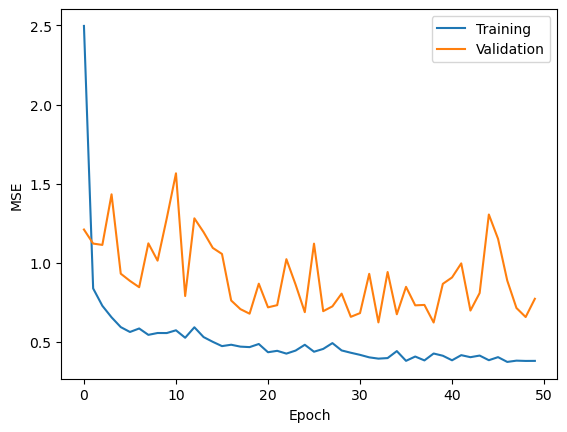

In [43]:
# Plot the training and validation loss values
plt.plot(trained_model.history['loss'], label='Training')
plt.plot(trained_model.history['val_loss'], label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [ ]:
##Analyzing Model Prediction

In [44]:
# Predict the surface precipitation rate from the training data
train_predict = model.predict(norm_train_features)

# Predict the surface precipitation rate from the validation data
val_predict = model.predict(norm_val_features)

3016/3016 [==============================] - 4s 1ms/step


Text(0.5, 1.0, 'Validation Set')

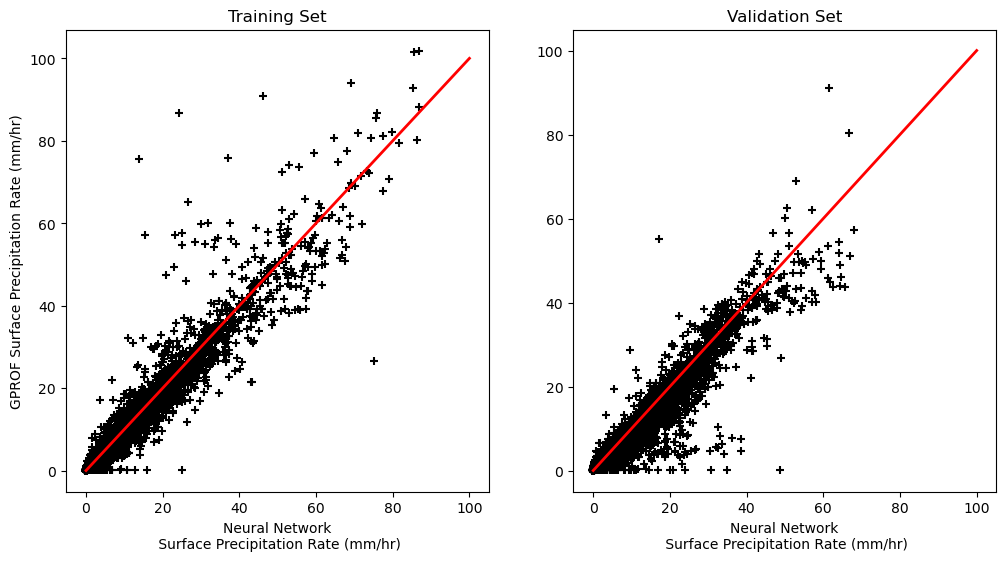

In [45]:
# Plot a scatter plot for the training and validation predictions
plt.figure(figsize=[12,6])

# For the training set
plt.subplot(1,2,1)
plt.scatter(train_predict,train_labels, marker="+", color="k")

# Plot a one-to-one line
plt.plot([0,100],[0,100], color="red", lw=2)

plt.xlabel("Neural Network\n Surface Precipitation Rate (mm/hr)")
plt.ylabel("GPROF Surface Precipitation Rate (mm/hr)")

plt.title("Training Set")

# For the validation set
plt.subplot(1, 2, 2)
plt.scatter(val_predict,val_labels, marker="+", color="k")

# Plot a one-to-one line
plt.plot([0, 100],[0, 100], color="red", lw=2)

plt.xlabel("Neural Network\n Surface Precipitation Rate (mm/hr)")

plt.title("Validation Set")

In [ ]:
## Applying the Artificial Neural Network Model to a TC PRIMED Overpass

In [46]:
# Retrieve a particular netCDF object from the test sample
DS = TEST_DS[TEST_FILE_NAMES[2]]

# Load the latitude and longitude values of the observation pixels
latitude = DS["passive_microwave/S1/latitude"][:]
longitude = DS["passive_microwave/S1/longitude"][:]


# convert the default longitude values in TC PRIMED with a longitude range of [0, 360) to the longitude range of [-180,180)
longitude[longitude >= 180] -= 360

# Get the shape of the input
input_shape = latitude.shape

# Using the latitude and longitude values of the pixels, find the
# pixels that are over the land. Pixels that are over the land will
# have a value of "True"
land_pixels = globe.is_land(latitude, longitude)

# Find the indices of the pixels that are over land
select_idx = np.argwhere(land_pixels == True)

# Initialize array for input features
test_features = []

# Loop through each observation frequency
for frequency in frequencies:

    # Load the brightness temperature field
    # Replace the masked value with -999.0
    TB = DS["passive_microwave/S1/TB_" + frequency][:].filled(-999.0)

    # Append indices of brightness temperature values that are
    # _FillValue to the indices we have already selected above
    select_idx = np.append(select_idx, np.argwhere(TB == -999.0), axis=0)

    # Get only unique indices
    select_idx = np.unique(select_idx, axis=0)

    # Put the input features into an array
    if frequency == frequencies[0]:

        test_features = TB.flatten()

    else:

        test_features = np.vstack((test_features, TB.flatten()))

# Transpose the input feature array for model ingest
test_features = np.transpose(test_features)

# Normalize test features
norm_test_features = normalize_input_features(frequencies, test_features, feature_min, feature_max)

# Load the x, y, and GPROF surface precipitation rates for plotting and
# to compare with the model predictions
# Use NaN value to replace masked value in GPROF surface precipitation
# rate variable, for plotting
x = DS["passive_microwave/S1/x"][:]
y = DS["passive_microwave/S1/y"][:]
GPROF_surfaceprecip = DS["GPROF/S1/surfacePrecipitation"][:].filled(np.nan)

# Make a prediction with the model
model_surfaceprecip = model.predict(norm_test_features)

# Reformat the output to match the input
model_surfaceprecip = model_surfaceprecip.reshape(input_shape)

# Loop through each index with land pixels or masked value in any of
# the input features
# Replace the model prediction with NaN for plotting
for idx in select_idx:

    model_surfaceprecip[idx[0], idx[1]] = np.nan

995/995 [==============================] - 1s 1ms/step


/tmp/ipykernel_16654/4059736624.py:31: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x, y, model_surfaceprecip, vmin=0, vmax=50, cmap=precip_colormap)
/tmp/ipykernel_16654/4059736624.py:41: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x, y, GPROF_surfaceprecip, vmin=0, vmax=50, cmap=precip_colormap)


(-500.0, 500.0)

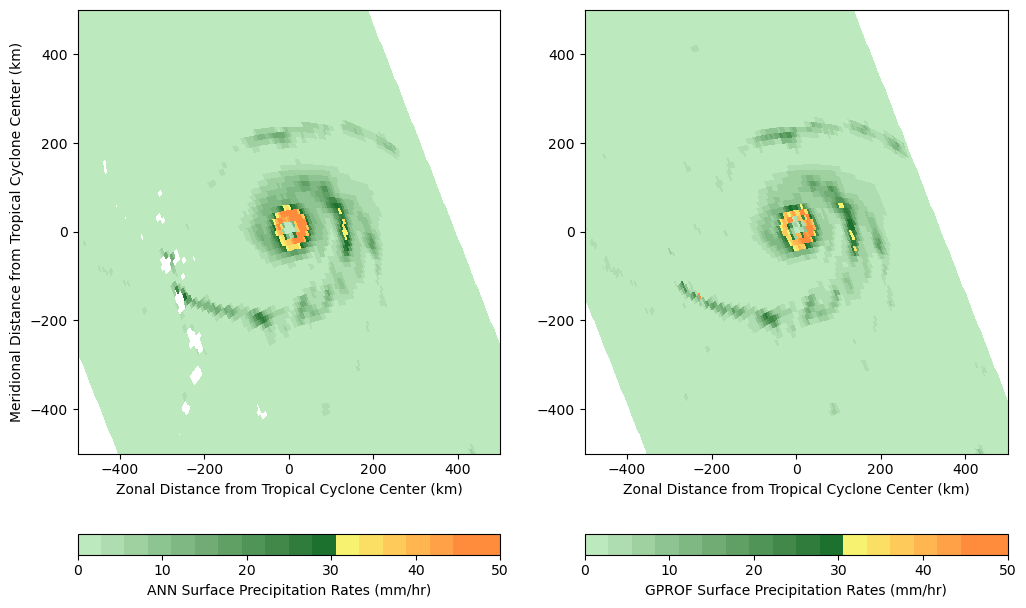

In [53]:
#colormap data
import matplotlib.colors as cls

precip_colors = [
   "#bde9bf",  # 0.01 - 0.02 inches 1
   "#adddb0",  # 0.02 - 0.03 inches 2
   "#9ed0a0",  # 0.03 - 0.04 inches 3
   "#8ec491",  # 0.04 - 0.05 inches 4
   "#7fb882",  # 0.05 - 0.06 inches 5
   "#70ac74",  # 0.06 - 0.07 inches 6
   "#60a065",  # 0.07 - 0.08 inches 7
   "#519457",  # 0.08 - 0.09 inches 8
   "#418849",  # 0.09 - 0.10 inches 9
   "#307c3c",  # 0.10 - 0.12 inches 10
   "#1c712e",  # 0.12 - 0.14 inches 11
   "#f7f370",  # 0.14 - 0.16 inches 12
   "#fbdf65",  # 0.16 - 0.18 inches 13
   "#fecb5a",  # 0.18 - 0.2 inches 14
   "#ffb650",  # 0.2 - 0.3 inches 15
   "#ffa146",  # 0.3 - 0.4 inches 16
   "#ff8b3c",   # 0.4 - 0.5 inches 17
   "#ff8b3c"   # 0.5 - 0.6 inches 18
]
precip_colormap = cls.ListedColormap(precip_colors)

# Set figure size
plt.figure(figsize=[12,8])

# For the model surface precipitation prediction
plt.subplot(1,2,1)
plt.pcolormesh(x, y, model_surfaceprecip, vmin=0, vmax=50, cmap=precip_colormap)
plt.colorbar(orientation="horizontal",pad=0.13, label="ANN Surface Precipitation Rates (mm/hr)")

plt.xlim(-500,500)
plt.xlabel("Zonal Distance from Tropical Cyclone Center (km)")
plt.ylim(-500,500)
plt.ylabel("Meridional Distance from Tropical Cyclone Center (km)")

# For the GPROF surface precipitation field
plt.subplot(1,2,2)
plt.pcolormesh(x, y, GPROF_surfaceprecip, vmin=0, vmax=50, cmap=precip_colormap)
plt.colorbar(orientation="horizontal",pad=0.13, label="GPROF Surface Precipitation Rates (mm/hr)")

plt.xlim(-500,500)
plt.xlabel("Zonal Distance from Tropical Cyclone Center (km)")
plt.ylim(-500,500)

In [ ]:
## Close the File

In [25]:
for train_file_name in TRAIN_FILE_NAMES:
    TRAIN_DS[train_file_name].close()

for val_file_name in VAL_FILE_NAMES:
    VAL_DS[val_file_name].close()

for test_file_name in TEST_FILE_NAMES:
    TEST_DS[test_file_name].close()